# Question 1 (50%)
You will train a multilayer perceptron neural network model using maximum likelihood parameter
estimation procedure to approximate the maximum a posteriori (MAP) classification rule,
which is the therotically optimal solution for minimizing probablity of error.

Part 1: Select data distribution.

• Select a data distribution for x 2 R3 that is a mixture of 4 Gaussians. Each Gaussian component
represents a class label.
• Select distinct (non-uniform) class priors (i.e. distinct Gaussian component weights in the
convex linear combination).
• Select distinct mean vectors and covariance matrices for each Gaussian class-conditional
probability distribution.
• Do not choose covariance matrices to be diagonal; and select each coariance matrix to have
distinct eigenvalues (so that your Gaussians are tilted with respect to coordinate axes and
have elongated ellipsoid equilevel contours).
• Choose the mean vectors and covariance matrices of the Gaussians to allow for a moderate
level of overlap between class distributions so that the theoretical minimum probability of
error is neither too small (e.g. <3%) nor too large (e.g. >25%). This will make the problem
more interesting.
• Clearly specify your data distribution and demonstrate it visually with a scatter plot using
an appropriate number of samples drawn in an iid fashion from your distribution (e.g., draw
1000 samples and plot them in a 3-dimensional scatter plot with class labels color coded).

Part 2: Determine and evaluate the theoretically optimal MAP classifier.

• For your selected data distribution, determine and specify the MAP-classification rule.
• Generate (at least) 10000 iid (test) samples (for which you know the class labels of course
since you generate them); apply the MAP classifier to these samples to get MAP-decision
labels.
• Counting the number of misclassified samples and dividing by the total number of samples,
estimate the theoretical minimum probability of error achievable for your data distribution.
• Save this test dataset for use in the next step.
• Present appropriate math, and visual/numerical results to convince the reader that you have
implemented the theoretical MAP classifier appropriately, and to approximate the theoretically
achieveable smallest error probability.

Part 3: Train and evaluate a classifier based on neural network based approximations of
the class label posteriors; for a given input data vector class label decision will be made by
selecting the neural network output index that has the largest value.

• Generate three separate training datasets from your data distribution; these datasets will
respectively have 100, 1000, and 10000 iid samples and their true labels.
• For each dataset, you will train a multilayer perceptron to approximate class posterior probabilities
given the data vector, using the maximum likelihood parameter estimation principle.
These neural networks will each have a single hidden layer (i.e. two layers of weight
matrices) with sigmoid outputs (choose your favorite from a suitable list, including logistic,
hyperbolic tangent, and softplus functions). For the output layer nonlinearity, use the
normalized exponential function (in order to ensure that your vector-valued output approximating
class posteriors for each class label are in the probability simplex). Determine and
present the necessary mathematical expression of the optimization problem that needs to be
solved to achieve this goal. Implement appropriately using your preferred software package.
Describe your implementation and explain how it matches the mathematical description of
the problem you specified.
• For each multilayer perceptron neural network you train on a given dataset, determine the
most appropriate number of perceptrons (units/nodes) in the hidden layer, use 10-fold crossvalidation
using probability of correct decisions as your performance measure (since it is 1
minus probability or error, and is consistent with our overarching objective to design a classifier
with the smallest possible error probability). Present appropriate math, descriptions,
visual and numerical results to convince the reader that you have done model order selection
appropriately using cross-validation.*
• Once you determine the best number of perceptrons that the training data justifies, train
your final neural network with appropriate model order to maximize data likelihood using
all training data in the given set.
• Apply your trained neural network classifiers to the test dataset that you generated and used
in the previous item where theoretically optimal MAP classifier was analyzed numerically.
Report the test dataset probability error estimates for your neural network classifiers trained
with different training dataset sizes. Discuss the effect of training set size on test dataset
performance for these neural network models.

* Note that if we had not commited to a minimum-probability-of-error classifier design upfront,
we could use log-likelihood of validation data as an appropriate model order selection objective in
the cross-validation process.

## Part 1

In [3]:
# Importing the necessary packages
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix

In [93]:
def comp_one(size):
    mean = [1, 2, 3]
    cov = make_spd_matrix(n_dim=3)
    return mean, cov, np.random.multivariate_normal(mean, cov, size)

In [94]:
def comp_two(size):
    mean = [-1, -2, 3]
    cov = make_spd_matrix(n_dim=3)
    return mean, cov, np.random.multivariate_normal(mean, cov, size)

In [95]:
def comp_three(size):
    mean = [1, -2, -3]
    cov = make_spd_matrix(n_dim=3)
    return mean, cov, np.random.multivariate_normal(mean, cov, size)

In [96]:
def comp_four(size):
    mean = [-1, 2, -3]
    cov = make_spd_matrix(n_dim=3)
    return mean, cov, np.random.multivariate_normal(mean, cov, size)

In [97]:
# Setting priors for each class
p1 = 0.2
p2 = 0.3
p3 = 0.4
p4 = 0.1

In [98]:
# Generating the dataset
dataset_dist = np.random.uniform(0, 1, 1000)
mean1, cov1, data1 = comp_one(len(dataset_dist[dataset_dist <= p1]))
mean2, cov2, data2 = comp_two(len([x for x in dataset_dist if x > p1 and x <= (p1+p2)]))
mean3, cov3, data3 = comp_three(len([x for x in dataset_dist if x > (p1+p2) and x <= (p1+p2+p3)]))
mean4, cov4, data4 = comp_four(len([x for x in dataset_dist if x > (p1+p2+p3)]))
dataset = np.vstack([data1[:, None], data2[:, None], data3[:, None], data4[:, None]])

<IPython.core.display.Javascript object>


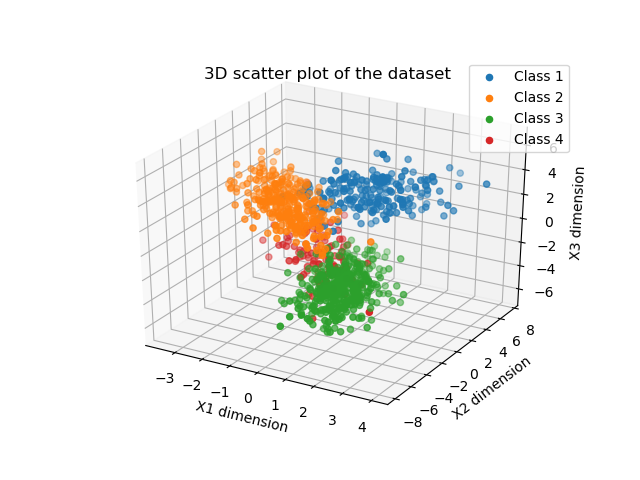

Text(0.5, 0.92, '3D scatter plot of the dataset')

In [99]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data1[:, 0], data1[:, 1], data1[:, 2], label='Class 1')
ax.scatter(data2[:, 0], data2[:, 1], data2[:, 2], label='Class 2')
ax.scatter(data3[:, 0], data3[:, 1], data3[:, 2], label='Class 3')
ax.scatter(data4[:, 0], data4[:, 1], data4[:, 2], label='Class 4')
ax.legend()
ax.set_xlabel('X1 dimension')
ax.set_ylabel('X2 dimension')
ax.set_zlabel('X3 dimension')
ax.set_title('3D scatter plot of the dataset')

## Part 2

In [100]:
from scipy.stats import multivariate_normal

#### Below I have implemented my MAP classifier.
#### The MAP classifier aims on achieving the minimum probability of error by incorporating the 0-1 loss.
#### The max of the product of the likelihood that a data point is part of a specific gaussian distribution and the prior of that gaussian distribution gives us the most likely class a data point originated from and helps us classify data points into their predicted class labels.
#### This is how the MAP classifier achieves minimum probability of error.

In [101]:
def return_map_classifier_label(data):
    map1 = p1*multivariate_normal(mean1, cov1).pdf(data)
    map2 = p2*multivariate_normal(mean2, cov2).pdf(data)
    map3 = p3*multivariate_normal(mean3, cov3).pdf(data)
    map4 = p4*multivariate_normal(mean4, cov4).pdf(data)
    return np.argmax([map1, map2, map3, map4])+1

In [102]:
correct_data1 = []
incorrect_data1 = []
correct_data2 = []
incorrect_data2 = []
correct_data3 = []
incorrect_data3 = []
correct_data4 = []
incorrect_data4 = []
correct_data = [correct_data1, correct_data2, correct_data3, correct_data4]
incorrect_data = [incorrect_data1, incorrect_data2, incorrect_data3, incorrect_data4]

In [103]:
for i, data_part in enumerate([data1, data2, data3, data4]):
    for data in data_part:
        if return_map_classifier_label(data) == (i+1):
            correct_data[i].append(data)
        else:
            incorrect_data[return_map_classifier_label(data)-1].append(data)

In [107]:
incorrect_data

[[array([-0.00968398,  0.12943913,  2.61466736])],
 [array([ 0.63082368, -1.20240913,  1.85979805]),
  array([ 0.19855416, -1.36487946,  1.3718375 ]),
  array([-0.20320773, -1.07259002,  2.53379394]),
  array([-0.32347138, -0.92011524,  2.39014618]),
  array([-0.08855629, -0.64873212,  2.06417513]),
  array([-0.86290045, -2.77732521,  3.8072357 ]),
  array([-0.42903544, -1.47025385,  4.30693292]),
  array([-1.04359697,  1.12982838,  2.84242794]),
  array([-0.53066601, -1.85780735,  3.87698712]),
  array([-0.66502308, -0.9382907 ,  3.57171505]),
  array([-0.84975526,  0.39656681,  2.86929307]),
  array([ 0.62981331, -1.80092458,  1.34672883]),
  array([-0.63096233, -1.05323604,  3.37153328]),
  array([-0.64411276, -0.1751399 ,  2.25497678]),
  array([-0.48436486, -1.11364668,  3.3480787 ])],
 [array([ 0.74479483,  2.18776941, -2.9794472 ]),
  array([ 0.54945548,  0.84963681, -3.83079341]),
  array([-0.3419494 , -0.17991127, -2.55242977]),
  array([ 0.40046955,  0.70685705, -3.78590857])

<IPython.core.display.Javascript object>


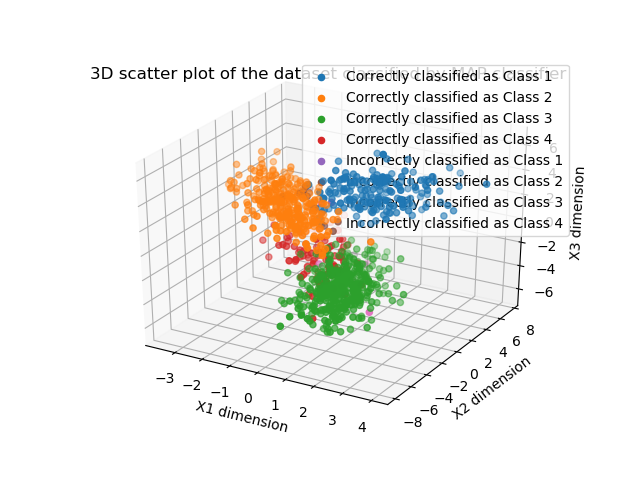

Text(0.5, 0.92, '3D scatter plot of the dataset classified by MAP classifier')

In [104]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(np.array(correct_data1)[:, 0], np.array(correct_data1)[:, 1], np.array(correct_data1)[:, 2], label='Correctly classified as Class 1')
ax.scatter(np.array(correct_data2)[:, 0], np.array(correct_data2)[:, 1], np.array(correct_data2)[:, 2], label='Correctly classified as Class 2')
ax.scatter(np.array(correct_data3)[:, 0], np.array(correct_data3)[:, 1], np.array(correct_data3)[:, 2], label='Correctly classified as Class 3')
ax.scatter(np.array(correct_data4)[:, 0], np.array(correct_data4)[:, 1], np.array(correct_data4)[:, 2], label='Correctly classified as Class 4')
try:
    ax.scatter(np.array(incorrect_data1)[:, 0], np.array(incorrect_data1)[:, 1], np.array(incorrect_data1)[:, 2], label='Incorrectly classified as Class 1')
except:
    pass
try:
    ax.scatter(np.array(incorrect_data2)[:, 0], np.array(incorrect_data2)[:, 1], np.array(incorrect_data2)[:, 2], label='Incorrectly classified as Class 2')
except:
    pass
try:
    ax.scatter(np.array(incorrect_data3)[:, 0], np.array(incorrect_data3)[:, 1], np.array(incorrect_data3)[:, 2], label='Incorrectly classified as Class 3')
except:
    pass
try:
    ax.scatter(np.array(incorrect_data4)[:, 0], np.array(incorrect_data4)[:, 1], np.array(incorrect_data4)[:, 2], label='Incorrectly classified as Class 4')
except:
    pass
ax.legend()
ax.set_xlabel('X1 dimension')
ax.set_ylabel('X2 dimension')
ax.set_zlabel('X3 dimension')
ax.set_title('3D scatter plot of the dataset classified by MAP classifier')

In [66]:
misclass_num = len(incorrect_data1)+len(incorrect_data2)+len(incorrect_data3)+len(incorrect_data4)
print('Number of misclassified samples are {}'.format(misclass_num))
print('Probability of error achieved is {}'.format(misclass_num/1000))

Number of misclassified samples are 2
Probability of error achieved is 0.002
